In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import healpy as hp
from scipy.spatial import ConvexHull

import lsdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import astropy.units as u


import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb
from lsst.ap.association import AssociationTask, AssociationConfig
from lsst.dax.apdb import Apdb, ApdbCassandra, ApdbTables
import lsst.geom
from lsst.afw import image as afwImage

from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize, ManualInterval, AsinhStretch, MinMaxInterval, LogStretch
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord

plt.set_loglevel('WARNING')

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


In [2]:
import pandas as pd
from pathlib import Path

# Base directory where the files are
base_dir = Path("/sdf/home/n/ncaplar")

# List of filenames
filenames = ["212_m7.tsv", "216_m17.tsv", "m49.tsv"]

# Column names based on your file structure
column_names = [
    '_RAJ2000', '_DEJ2000', 'Source', 'PF', 'P1O',
    'Gmagavg', 'RA_ICRS', 'DE_ICRS'
]

# Dictionary to store the dataframes
dfs = {}

for file in filenames:
    file_path = base_dir / file
    
    # Read and find where the actual data starts
    with open(file_path, "r") as f:
        lines = f.readlines()

    start_idx = None
    for i, line in enumerate(lines):
        if line.strip().startswith('_RAJ2000|'):
            start_idx = i
            break

    if start_idx is None:
        raise ValueError(f"Could not find table header in {file}")

    data_start = start_idx + 3  # skip header + units + dashed lines

    # Read the actual table
    df = pd.read_csv(
        file_path,
        sep="|",
        skiprows=data_start,
        names=column_names,
        engine="python",
    )

    df.columns = df.columns.str.strip()
    dfs[file.replace(".tsv", "")] = df  # store with nice key like '212_m7'

# Unpack individual DataFrames
df_212_m7 = dfs["212_m7"]
df_216_m17 = dfs["216_m17"]
df_m49 = dfs["m49"]

# Example: print how many rows were loaded
for name, df in dfs.items():
    print(f"{name}: {len(df)} rows loaded.")

212_m7: 393 rows loaded.
216_m17: 316 rows loaded.
m49: 306 rows loaded.


In [3]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

def create_mag(sciFlux):
    """Move flux into magnitudes
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux

    Returns
    -------
    mag  : `float`
        Magnitude
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    
    return mag

In [4]:
repo = "embargo"
collection = "LSSTCam/runs/DRP/20250415_20250422/d_2025_04_23/DM-50409"
instrument = "LSSTCam"

butler = dafButler.Butler(repo, collections=collection, instrument=instrument)

INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/n/ncaplar/.lsst/aws-credentials.ini


In [5]:
repo = "embargo"
collection = "LSSTCam/runs/DRP/20250420_20250429/w_2025_18/DM-50628"
instrument = "LSSTCam"

butler = dafButler.Butler(repo, collections=collection, instrument=instrument)

In [6]:
lc_refs = butler.query_datasets("dia_source")
# obj_refs = butler.query_datasets("dia_object")
obj_refs = butler.query_datasets("object")
diaobj_refs = butler.query_datasets("dia_object")
print(len(lc_refs))
print(len(obj_refs))
print(len(diaobj_refs))

46
52
46


In [7]:
"""
bands = ["u", "g", "r", "i", "z", "y"]
verbose = False

for band in bands:
    try:
        datasetRefs_dia = list(
            butler.query_datasets(
                "dia_source_detector",
                where=f"band='{band}'",
                limit=None  # Remove dataset limit
            )
        )
    except Exception as e:
        print(f"Error querying band '{band}': {e}")
        datasetRefs_dia = []

    if verbose and datasetRefs_dia:
        print(f"\nDataset references for band '{band}':")
        for dr in datasetRefs_dia:
            print(dr)

    print(f"Found {len(datasetRefs_dia)} dia_source_detector datasets for band '{band}'")
"""

'\nbands = ["u", "g", "r", "i", "z", "y"]\nverbose = False\n\nfor band in bands:\n    try:\n        datasetRefs_dia = list(\n            butler.query_datasets(\n                "dia_source_detector",\n                where=f"band=\'{band}\'",\n                limit=None  # Remove dataset limit\n            )\n        )\n    except Exception as e:\n        print(f"Error querying band \'{band}\': {e}")\n        datasetRefs_dia = []\n\n    if verbose and datasetRefs_dia:\n        print(f"\nDataset references for band \'{band}\':")\n        for dr in datasetRefs_dia:\n            print(dr)\n\n    print(f"Found {len(datasetRefs_dia)} dia_source_detector datasets for band \'{band}\'")\n'

In [8]:
# Initialize list to hold object DataFrames
object_list = []

# Loop over tracts via obj_refs
for obj_ref in tqdm(obj_refs):
    try:
        # Load full object table for this tract
        table = butler.get("object", dataId=obj_ref.dataId, parameters={'columns': ['objectId', 'tract', 'patch',
                                                                                    'u_ra', 'u_dec', 'u_psfFlux', 'u_psfFluxErr',
                                                                                    'g_ra', 'g_dec', 'g_psfFlux', 'g_psfFluxErr',
                                                                                    'r_ra', 'r_dec', 'r_psfFlux', 'r_psfFluxErr',
                                                                                    'i_ra', 'i_dec', 'i_psfFlux', 'i_psfFluxErr']})
        # table = butler.get("object", dataId=obj_ref.dataId)
        df = table.to_pandas()
        object_list.append(df)
    except FileNotFoundError:
        print(f"Warning: objectTable_tract not found for tract {obj_ref.dataId['tract']}. Skipping.")

# Concatenate into one DataFrame
objects = pd.concat(object_list, ignore_index=True) if object_list else pd.DataFrame()

  0%|          | 0/52 [00:00<?, ?it/s]INFO:aiobotocore.credentials:Found credentials in shared credentials file: /sdf/home/n/ncaplar/.lsst/aws-credentials.ini


100%|██████████| 52/52 [00:35<00:00,  1.47it/s]


In [9]:
objects['mean_ra'] = objects[[f'{b}_ra' for b in ['u', 'g', 'r', 'i']]].mean(axis=1, skipna=True)
objects['mean_dec'] = objects[[f'{b}_dec' for b in ['u', 'g', 'r', 'i']]].mean(axis=1, skipna=True)
objects

,objectId,tract,patch,u_ra,u_dec,u_psfFlux,u_psfFluxErr,g_ra,g_dec,g_psfFlux,...,r_ra,r_dec,r_psfFlux,r_psfFluxErr,i_ra,i_dec,i_psfFlux,i_psfFluxErr,mean_ra,mean_dec
0,24292472465129478,3535,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,229.021869,-40.107814,8515.582031,411.535919,229.021869,-40.107814
1,24292472465129479,3535,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,229.018383,-40.104596,4501.134277,407.966187,229.018383,-40.104596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3725482,23007212091742000,3347,99,NaN,NaN,NaN,NaN,226.713018,-40.165334,13254.273438,...,NaN,NaN,NaN,NaN,226.713022,-40.165335,29182.349609,68.543968,226.713020,-40.165335
3725483,23007212091742018,3347,99,NaN,NaN,NaN,NaN,226.711751,-40.165408,737.807678,...,NaN,NaN,NaN,NaN,226.711766,-40.165416,10611.800781,63.528614,226.711759,-40.165412


In [10]:
# Initialize list to hold object DataFrames
diaobject_list = []

# Loop over tracts via obj_refs
for diaobj_ref in tqdm(diaobj_refs):
    try:
        # Load full object table for this tract
        table = butler.get("dia_object", dataId=diaobj_ref.dataId)
        # table = butler.get("object", dataId=obj_ref.dataId)
        diaobject_list.append(table)
    except FileNotFoundError:
        print(f"Warning: objectTable_tract not found for tract {diaobject_list.dataId['tract']}. Skipping.")

# Concatenate into one DataFrame
diaobjects = pd.concat(diaobject_list, ignore_index=False) if diaobject_list else pd.DataFrame()

  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [00:07<00:00,  6.30it/s]


In [11]:
diaobjects

,ra,dec,nDiaSources,radecMjdTai,g_psfFluxLinearSlope,g_psfFluxLinearIntercept,g_psfFluxMAD,g_psfFluxMaxSlope,g_psfFluxErrMean,g_psfFluxMean,...,u_psfFluxPercentile05,u_psfFluxPercentile25,u_psfFluxPercentile50,u_psfFluxPercentile75,u_psfFluxPercentile95,u_psfFluxSigma,u_scienceFluxSigma,u_psfFluxSkew,u_psfFluxChi2,u_psfFluxStetsonJ
diaObjectId,,,,,,,,,,,,,,,,,,,,,
56068221068902401,210.684005,-8.908830,6,60795.279521,-5209.334246,3.166973e+08,2536.671387,-5216.316723,258.101288,3.245296e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56068221068902402,210.679285,-8.899452,3,60794.268648,NaN,NaN,0.000000,NaN,156.223724,8.062990e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57723810702426156,209.561623,-5.971951,1,60795.290928,NaN,NaN,0.000000,NaN,3949.982178,1.296427e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57723810702426157,209.561740,-5.955250,1,60795.290928,NaN,NaN,0.000000,NaN,401.829193,2.287379e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#plt.scatter(diaobjects['ra'], diaobjects['dec'], s=1, alpha=0.5)

In [13]:
objects_m49 = objects[objects['mean_ra'].between(180, 192) & objects['mean_dec'].between(1, 13)]
diaobjects_m49 = diaobjects[diaobjects['ra'].between(180, 192) & diaobjects['dec'].between(1, 13)]


In [14]:
diaobjects_m49 = diaobjects_m49.copy()
diaobjects_m49['diaObjectId'] = diaobjects_m49.index
df_m49['ra'] = df_m49['_RAJ2000']
df_m49['dec'] = df_m49['_DEJ2000']

In [15]:
RR_LSST = lsdb.crossmatch(df_m49[['ra', 'dec', 'PF','P1O']], diaobjects_m49[['ra', 'dec', 'diaObjectId']].reset_index(drop=True), radius_arcsec=0.10)
RR_LSST_computed = RR_LSST.compute()

(array([ 3.,  9., 13., 11., 11., 13.,  4.,  5.,  4.,  8.]),
 array([0.00304457, 0.01136623, 0.01968789, 0.02800955, 0.03633121,
        0.04465288, 0.05297454, 0.0612962 , 0.06961786, 0.07793952,
        0.08626118]),
 <BarContainer object of 10 artists>)

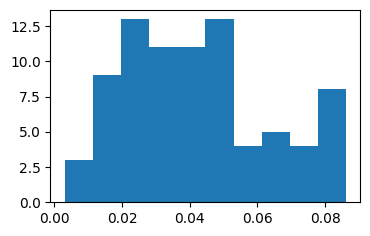

In [16]:
plt.figure(figsize=(4, 2.5))
plt.hist(RR_LSST_computed['_dist_arcsec'])

In [17]:
# this is silly because I have tract patch information in the object table
import lsst.geom as geom

# Get the skymap once
skymap = butler.get("skyMap", skymap="lsst_cells_v1")

# Prepare storage for tract and patch values
tracts = []
patches = []

# Loop through the table and compute tract/patch for each coordinate
for ra, dec in zip(RR_LSST_computed["ra_left"], RR_LSST_computed["dec_left"]):
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    
    tr_id = tractInfo.getId()
    pt_idx = patchInfo.getIndex()  # tuple like (x, y)
    
    tracts.append(tr_id)
    patches.append(f"{pt_idx[0]},{pt_idx[1]}")  # optional: convert to string for easier saving/plotting

# Add as new columns to the original DataFrame
RR_LSST_computed["tract"] = tracts
RR_LSST_computed["patch"] = patches

In [18]:
# list of unique tract values
RR_LSST_computed['tract'].unique()

array([10079, 10078, 10080, 10322, 10564, 10320, 10319, 10561, 10321,
       10562, 10563, 10803, 10804, 10802, 11043, 10805, 11045, 11044])

In [19]:
RR_LSST_computed

,ra_left,dec_left,PF_left,P1O_left,ra_right,dec_right,diaObjectId_right,_dist_arcsec,tract,patch
_healpix_29,,,,,,,,,,
1850831696860195171,186.221399,3.895188,0.50838453935039618,,186.221407,3.895176,69266689929248812,0.048889,10079,"3,6"
1850882317707649174,184.67884,3.658117,0.61388086476628556,,184.678838,3.658126,69258443592040462,0.031165,10078,"3,4"
...,...,...,...,...,...,...,...,...,...,...
1951958709799179074,187.036417,9.633211,0.60270167114801398,,187.036403,9.633203,75897019922645029,0.055565,11044,"7,4"
1951964200700037681,187.311773,9.858135,0.57356163184774900,,187.311769,9.858133,75898325592703045,0.014547,11044,"6,6"


In [20]:
tract_ids = RR_LSST_computed['tract'].unique()
tract_list_str = ", ".join(str(t) for t in tract_ids)

forcedSource_refs = butler.query_datasets(
    "dia_object_forced_source",
    where=f"tract IN ({tract_list_str}) AND skymap='lsst_cells_v1'"
)

print(len(forcedSource_refs))

1431


In [21]:
import pandas as pd
"""
# Step 1: Prepare your list of target objectIds
target_objectIds = set(RR_LSST_computed['diaObjectId_right'].values)

# Step 3: Loop through datasets and filter by objectId
matched_forced_sources = []

for ref in tqdm(forcedSource_refs):
    try:
        table = butler.get(ref)  # Astropy table
        df = table.to_pandas()

        # Filter only the objectIds you're interested in
        df_filtered = df[df["diaObjectId"].isin(target_objectIds)]
        if not df_filtered.empty:
            matched_forced_sources.append(df_filtered)

    except Exception as e:
        print(f"Warning: Failed to load {ref.dataId} — {e}")

# Step 4: Combine all matched rows into one DataFrame
if matched_forced_sources:
    all_forced_sources = pd.concat(matched_forced_sources, ignore_index=True)
    print(f"Retrieved {len(all_forced_sources)} forced source rows for {len(target_objectIds)} objectIds.")
else:
    all_forced_sources = pd.DataFrame()
    print("No forced sources found.")
"""

'\n# Step 1: Prepare your list of target objectIds\ntarget_objectIds = set(RR_LSST_computed[\'diaObjectId_right\'].values)\n\n# Step 3: Loop through datasets and filter by objectId\nmatched_forced_sources = []\n\nfor ref in tqdm(forcedSource_refs):\n    try:\n        table = butler.get(ref)  # Astropy table\n        df = table.to_pandas()\n\n        # Filter only the objectIds you\'re interested in\n        df_filtered = df[df["diaObjectId"].isin(target_objectIds)]\n        if not df_filtered.empty:\n            matched_forced_sources.append(df_filtered)\n\n    except Exception as e:\n        print(f"Warning: Failed to load {ref.dataId} — {e}")\n\n# Step 4: Combine all matched rows into one DataFrame\nif matched_forced_sources:\n    all_forced_sources = pd.concat(matched_forced_sources, ignore_index=True)\n    print(f"Retrieved {len(all_forced_sources)} forced source rows for {len(target_objectIds)} objectIds.")\nelse:\n    all_forced_sources = pd.DataFrame()\n    print("No forced sour

In [22]:
# all_forced_sources.to_parquet("/sdf/group/rubin/shared/notebooks/mjuric/rfl/variable_objects/all_forced_sources.parquet")
all_forced_sources = pd.read_parquet("/sdf/group/rubin/shared/notebooks/mjuric/rfl/variable_objects/all_forced_sources.parquet")

In [23]:
target_objectIds = all_forced_sources['diaObjectId'].unique()

In [24]:
# add length of lightcurve to RR_LSST_computed 

# Step 1: Count number of forced source rows per objectId
lc_lengths = (
    all_forced_sources
    .groupby("diaObjectId")
    .size()
    .reset_index(name="lc_length")  # column with the lightcurve length
)

# Step 2: Merge into RR_LSST_computed using objectId_right
RR_LSST_computed_with_length = RR_LSST_computed.merge(
    lc_lengths,
    how='left',
    left_on='diaObjectId_right',
    right_on='diaObjectId'
)

# Optional: drop duplicate objectId column if desired
RR_LSST_computed_with_length = RR_LSST_computed_with_length.drop(columns=["diaObjectId"])

In [25]:
# Remove entries that are empty or contain only whitespace
mask = RR_LSST_computed_with_length['PF_left'].str.strip() != ''
RR_LSST_computed_with_length = RR_LSST_computed_with_length[mask].copy()

# Optionally convert 'PF_left' to float
RR_LSST_computed_with_length['PF_left'] = RR_LSST_computed_with_length['PF_left'].astype(float)

In [26]:
RR_LSST_computed_long = RR_LSST_computed_with_length[(RR_LSST_computed_with_length['lc_length']>120) ]
RR_LSST_computed_long

,ra_left,dec_left,PF_left,P1O_left,ra_right,dec_right,diaObjectId_right,_dist_arcsec,tract,patch,lc_length
19,184.59679,5.511439,0.584454,,184.596786,5.511435,70922898038063355,0.021285,10320,"4,6",137
24,185.80208,4.953157,0.551756,,185.802068,4.953153,70927777120911428,0.044038,10321,"5,3",133
25,185.269316,5.443003,0.509457,,185.269308,5.442993,70930113583120393,0.04453,10321,"9,6",164
26,184.852644,5.446231,0.593852,,184.852649,5.446228,70922760599109666,0.021648,10320,"2,6",138
27,184.755311,6.044522,0.535131,,184.755304,6.04452,72582679559667804,0.028736,10562,"7,1",156
28,186.264062,6.541789,0.567277,,186.264063,6.541785,72591613091643579,0.013602,10563,"7,4",244
29,185.678876,6.870694,0.765155,,185.678873,6.870687,72585771936120852,0.024921,10562,"2,6",214
30,185.315659,6.844104,0.814494,,185.315661,6.8441,72585222180306972,0.016416,10562,"4,5",199
31,187.560496,6.544174,0.602569,,187.560491,6.54418,72598553758793795,0.025312,10564,"8,4",148
32,187.879632,7.249899,0.530345,,187.879623,7.249885,72601233818386459,0.059418,10564,"7,8",166


In [27]:
# parameters of good RR Lyrae
RR_LSST_computed_long.to_parquet("/sdf/group/rubin/shared/notebooks/mjuric/rfl/variable_objects/RR_LSST_computed_long.parquet")

In [28]:
obj_id_longest = int(RR_LSST_computed_long[RR_LSST_computed_long['lc_length'] == np.max(RR_LSST_computed_long['lc_length'])]['diaObjectId_right'])

In [29]:
# example of a lightcurve
single_lc = all_forced_sources[all_forced_sources['diaObjectId'] == obj_id_longest]
single_lc

,diaObjectId,parentObjectId,coord_ra,coord_dec,visit,detector,band,psfFlux,psfFluxErr,psfFlux_flag,...,pixelFlags_interpolatedCenter,pixelFlags_nodata,pixelFlags_saturated,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,invalidPsfFlag,tract,patch,forcedSourceOnDiaObjectId
4479,72591613091643579,0,186.264063,6.541785,2025042700358,1,u,66531.718750,658.261780,False,...,False,False,False,False,False,False,False,10563,47,24607118280110389
4480,72591613091643579,0,186.264063,6.541785,2025042700404,1,g,112648.640625,426.970367,False,...,False,False,False,False,False,False,False,10563,47,24607124454113948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4721,72591613091643579,0,186.264063,6.541785,2025042900305,187,u,24070.568359,528.835999,False,...,False,False,False,False,False,False,False,10563,47,24615907357108987
4722,72591613091643579,0,186.264063,6.541785,2025042900308,187,u,28015.078125,473.642609,False,...,False,False,False,False,False,False,False,10563,47,24615907759755521


In [30]:
visit_ids = all_forced_sources['visit'].unique()
np.save("/sdf/home/n/ncaplar/rrlyrae_lightcurves/visit_ids.npy", visit_ids)

In [31]:
times = np.load('/sdf/home/n/ncaplar/rrlyrae_lightcurves/times.npy')

In [32]:
filtered_visits_df = pd.read_parquet("/sdf/group/rubin/shared/notebooks/mjuric/rfl/variable_objects/filtered_visits_df.parquet")

In [33]:
filtered_visits_df['visit_id']

162     2025042100128
163     2025042100129
            ...      
1287    2025042900350
1288    2025042900351
Name: visit_id, Length: 367, dtype: int64

In [34]:
# Sanity check that the length matches
assert len(visit_ids) == len(times), "Mismatch in number of visits and MJD times"

# Step 3: Create a mapping dictionary
visit_to_mjd = dict(zip(filtered_visits_df['visit_id'], filtered_visits_df['exp_midpt_mjd']))

# Step 4: Map the MJD to the all_forced_sources DataFrame
all_forced_sources['mjd'] = all_forced_sources['visit'].map(visit_to_mjd)

In [35]:

object_id = RR_LSST_computed_long['diaObjectId_right'].unique()[11]
single_lc = all_forced_sources[all_forced_sources['diaObjectId'] == object_id].copy()
single_lc

,diaObjectId,parentObjectId,coord_ra,coord_dec,visit,detector,band,psfFlux,psfFluxErr,psfFlux_flag,...,pixelFlags_nodata,pixelFlags_saturated,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,invalidPsfFlag,tract,patch,forcedSourceOnDiaObjectId,mjd
1536,74246446810923010,0,186.862379,7.813871,2025042900266,37,g,6.180511e+05,550.104431,False,...,False,True,True,True,True,False,10804,28,24615902043966367,60795.148974
1537,74246446810923010,0,186.862379,7.813871,2025042800230,38,r,2.982446e+06,1579.281982,False,...,False,False,False,False,False,False,10804,28,24611499166138370,60794.167914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,74246446810923010,0,186.862379,7.813871,2025042400246,182,i,2.368453e+06,1553.515137,False,...,False,False,False,False,False,False,10804,28,24593909203075769,60790.189989
1734,74246446810923010,0,186.862379,7.813871,2025042900307,185,u,1.362445e+06,2406.964600,False,...,False,False,False,False,False,False,10804,28,24615907624488354,60795.180079


In [45]:
good_index =  np.array([70927777120911428, 72591613091643579, 74238475351621650, 72584053949202434, 74241224130691123, 74242667239702535, 74249126870515736, 74244522665574412,  75894133704622083, 75895508094156806 ])

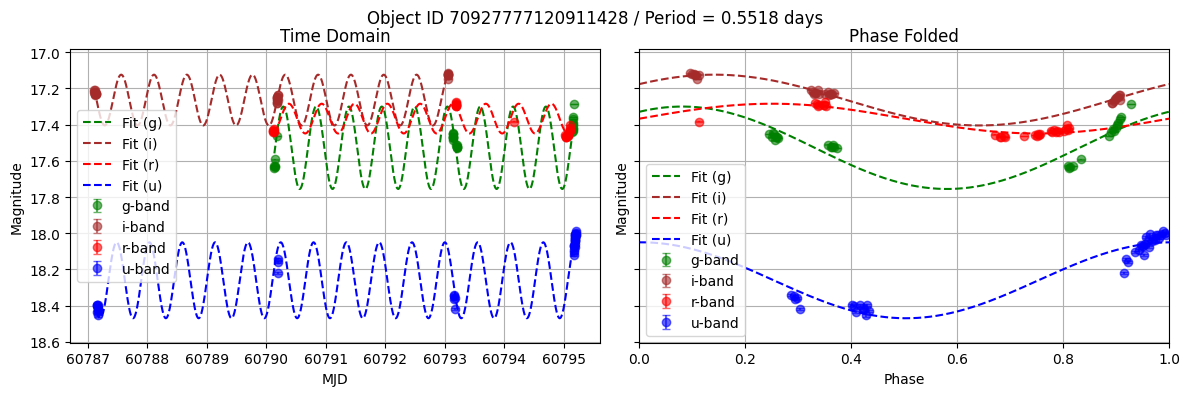

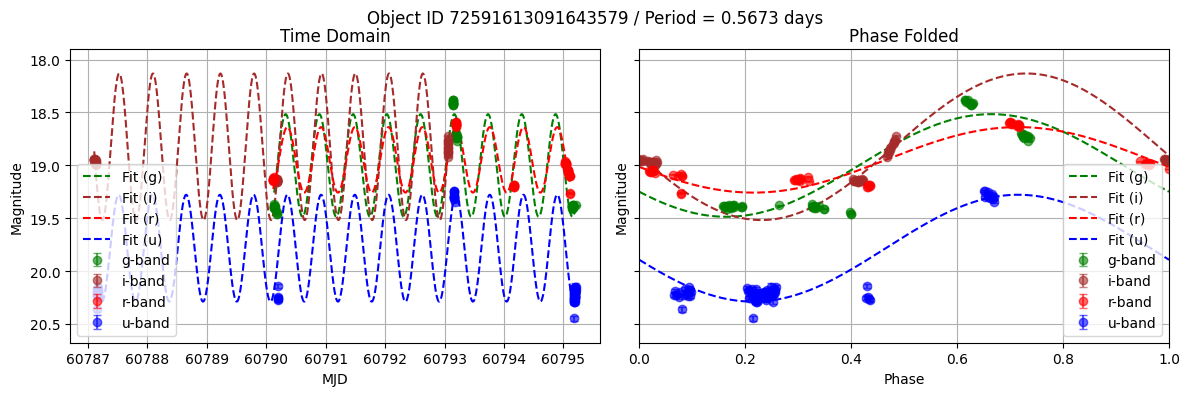

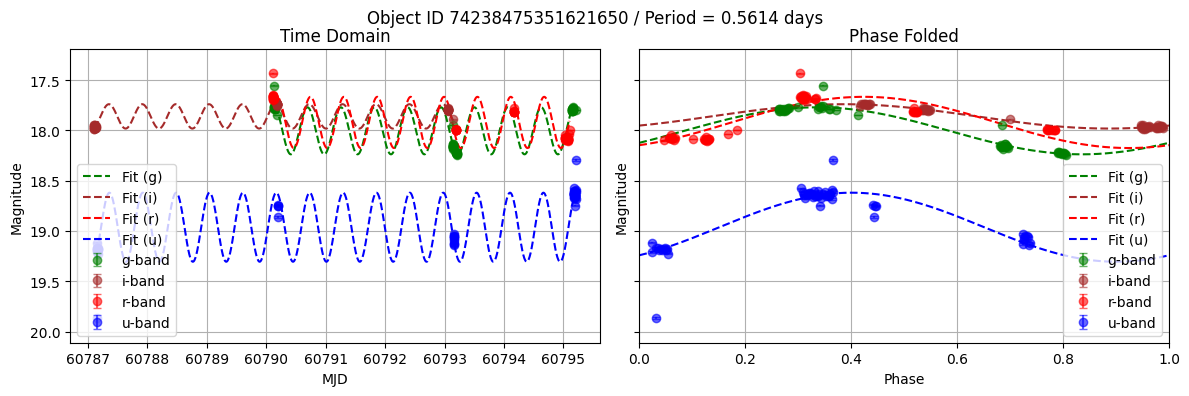

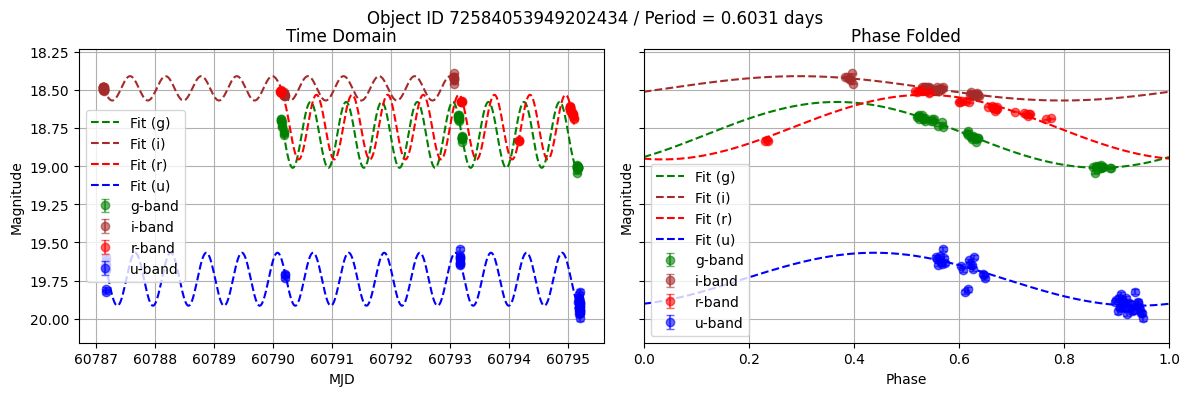

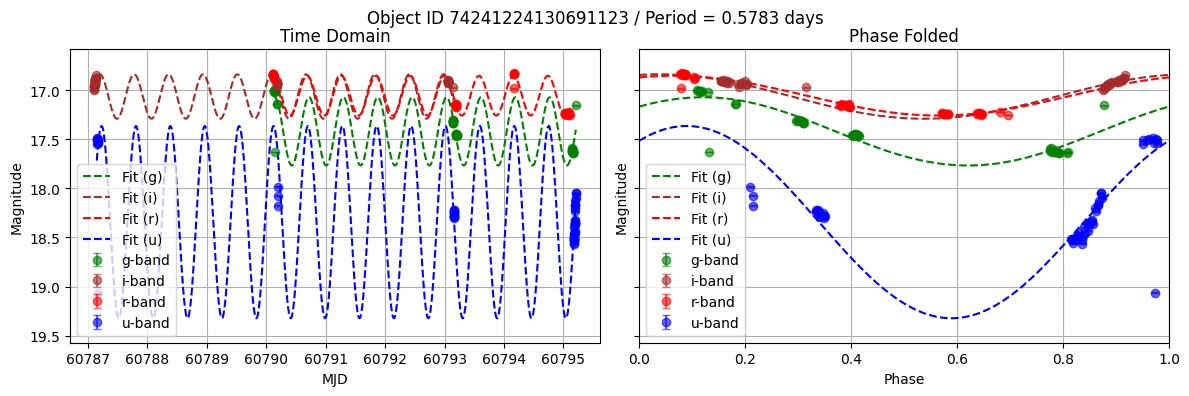

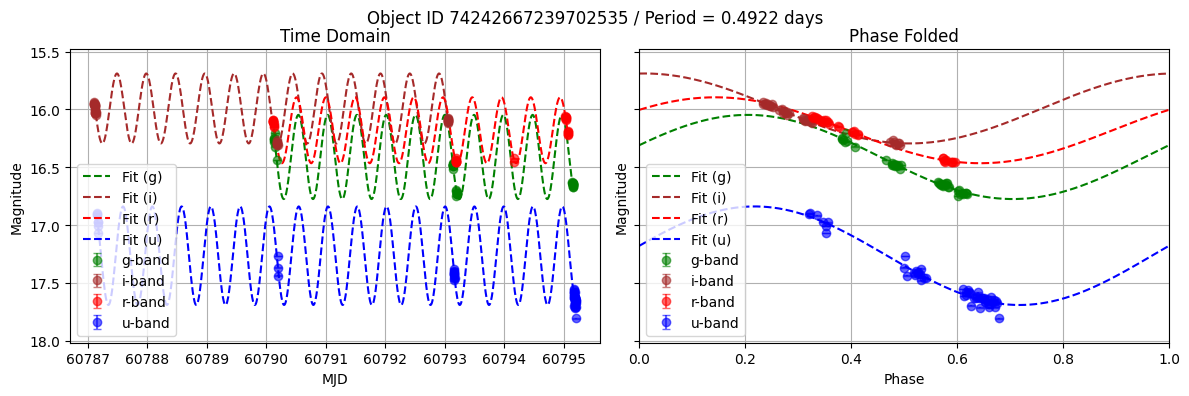

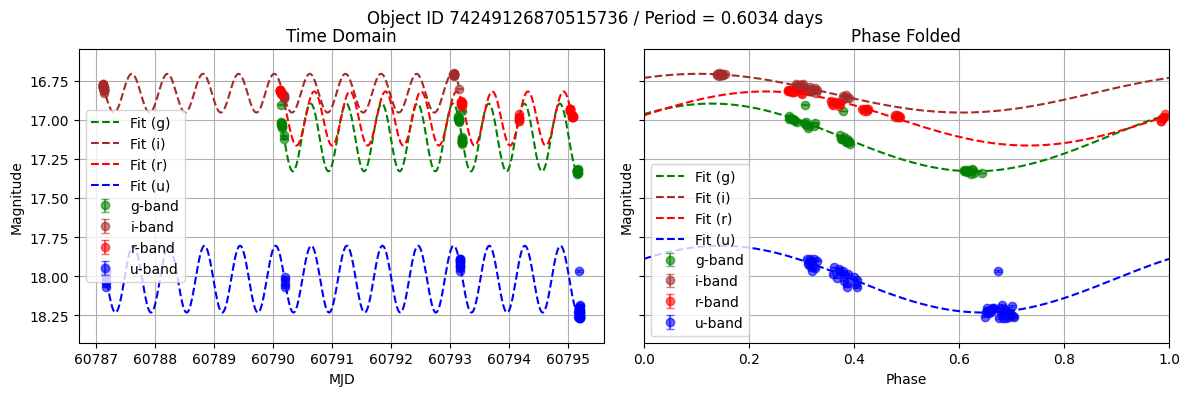

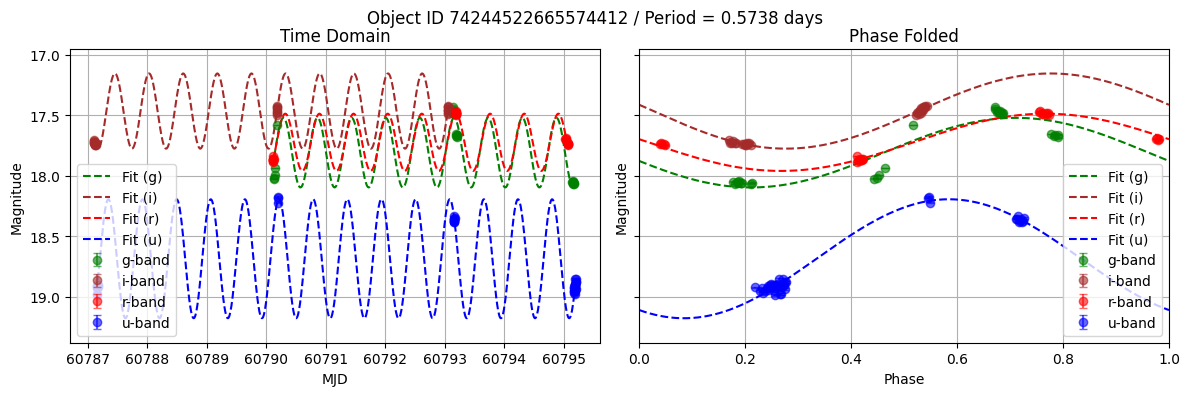

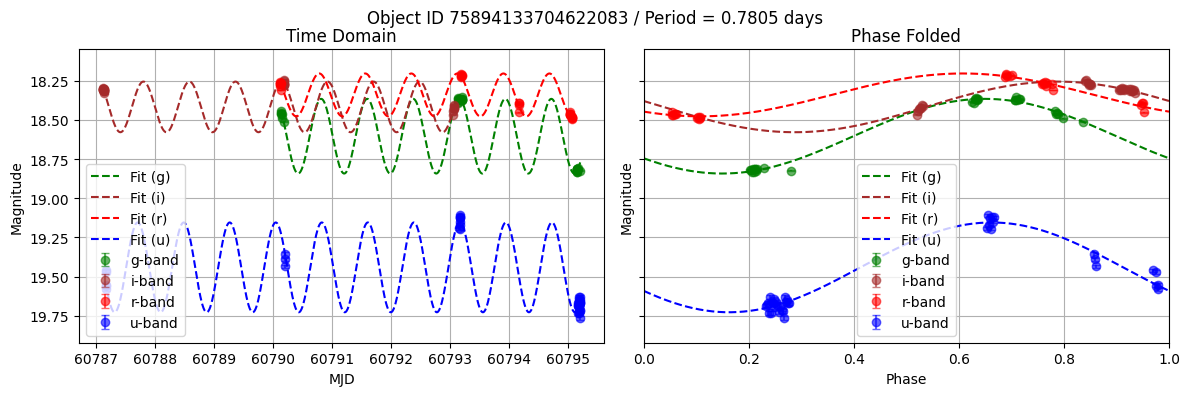

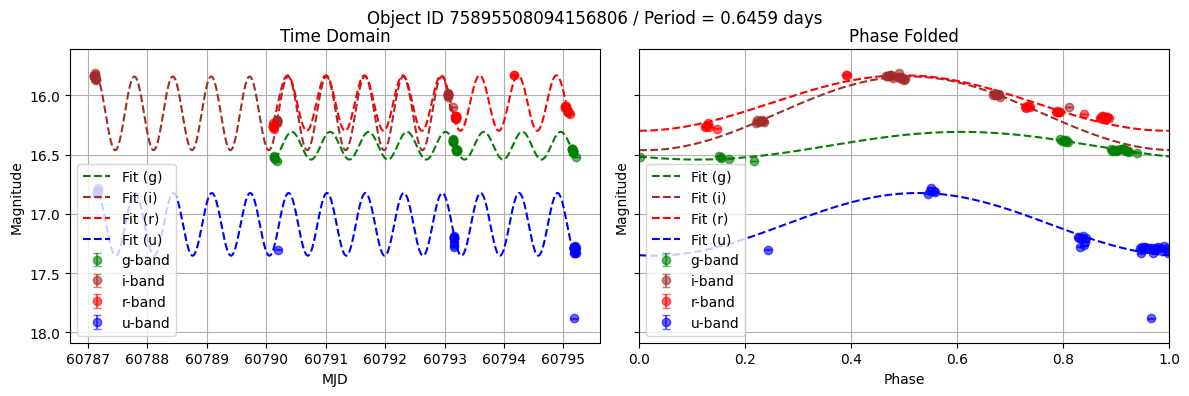

In [46]:
band_colors = {
    "u": "blue",
    "g": "green",
    "r": "red",
    "i": "brown"
}

def sinusoid(phase, A, phi0, mean_mag):
    return mean_mag + A * np.sin(2 * np.pi * phase + phi0)

for object_id in good_index:
    base_path = "/sdf/group/rubin/shared/notebooks/mjuric/rfl/variable_objects/test"
    
    # Load main lightcurve table
    lc_path = f"{base_path}/w_18_objectId_{int(object_id)}.parquet"
    single_lc = pd.read_parquet(lc_path)
    
    # Apply flag filtering if needed
    flag_cols = [col for col in single_lc.columns if 'flag' in col]
    if flag_cols:
        single_lc = single_lc[~single_lc[flag_cols].any(axis=1)]

    period = None  # Initialize period

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    global_ymin = np.inf
    global_ymax = -np.inf

    for band, group in single_lc.groupby("band"):
        try:
            # Load per-band lightcurve
            lc_band_path = f"{base_path}/w_18_objectId_lightcurve_{int(object_id)}_{band}.parquet"
            lc_df = pd.read_parquet(lc_band_path)

            # Load fit parameters
            fit_path = f"{base_path}/w_18_objectId_popt_{int(object_id)}_{band}.parquet"
            fit_df = pd.read_parquet(fit_path)
            A, phi0, mean_mag = fit_df.loc[0, ['A', 'phi0', 'mean_mag']]
            period = fit_df.loc[0, 'period']

            # Extract data
            time = lc_df["mjd"].values
            mag = lc_df["mag"].values
            mag_err = lc_df["magErr"].values
            phase = lc_df["phase"].values

            # Model values
            phase_model = np.linspace(0, 1, 500)
            mag_model_phase = sinusoid(phase_model, A, phi0, mean_mag)

            t_model = np.linspace(np.min(time), np.max(time), 1000)
            phase_t_model = (t_model % period) / period
            mag_model_time = sinusoid(phase_t_model, A, phi0, mean_mag)

            # Update y-limits
            combined_mags = np.concatenate([mag, mag_model_phase, mag_model_time])
            global_ymin = min(global_ymin, np.nanmin(combined_mags))
            global_ymax = max(global_ymax, np.nanmax(combined_mags))

            # Plot: time domain
            axes[0].errorbar(time, mag, yerr=mag_err, fmt='o', label=f"{band}-band",
                             alpha=0.6, color=band_colors.get(band, 'gray'), capsize=3)
            axes[0].plot(t_model, mag_model_time, '--',
                         label=f"Fit ({band})", color=band_colors.get(band, 'gray'))

            # Plot: phase-folded
            axes[1].errorbar(phase, mag, yerr=mag_err, fmt='o', label=f"{band}-band",
                             alpha=0.6, color=band_colors.get(band, 'gray'), capsize=3)
            axes[1].plot(phase_model, mag_model_phase, '--',
                         label=f"Fit ({band})", color=band_colors.get(band, 'gray'))

        except Exception as e:
            print(f"Failed for object {object_id}, band {band}: {e}")
            continue

    for ax in axes:
        ax.invert_yaxis()
        ax.legend()
        ax.grid(True)
        ax.set_ylabel("Magnitude")

    axes[0].set_xlabel("MJD")
    axes[0].set_title("Time Domain")

    axes[1].set_xlabel("Phase")
    axes[1].set_xlim(0, 1)
    axes[1].set_title("Phase Folded")

    if period is not None:
        plt.suptitle(f"Object ID {object_id} / Period = {period:.4f} days")
    else:
        plt.suptitle(f"Object ID {object_id} / Period unknown")

    pad = 0.1 * (global_ymax - global_ymin)
    axes[0].set_ylim(global_ymax + pad, global_ymin - pad)
    axes[1].set_ylim(global_ymax + pad, global_ymin - pad)

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

In [ ]:
object_id = RR_LSST_computed_long['diaObjectId_right'].unique()[0]
# Get one object's lightcurve and period
#object_id = RR_LSST_computed_long['objectId_right'].values[7]
single_lc = all_forced_sources[all_forced_sources['diaObjectId'] == object_id].copy()
single_lc['psfMag'] = create_mag(single_lc['psfFlux'])
single_lc_with_columns = single_lc[['visit', 'coord_ra', 'coord_dec', 'tract', 'patch', 'forcedSourceOnDiaObjectId', 'diaObjectId', 'detector', 'mjd', 'psfFlux', 'psfMag', 'band' ]]

In [38]:
object_id = RR_LSST_computed_long['diaObjectId_right'].unique()[0]
# Get one object's lightcurve and period
#object_id = RR_LSST_computed_long['objectId_right'].values[7]
single_lc = all_forced_sources[all_forced_sources['diaObjectId'] == object_id].copy()
single_lc['psfMag'] = create_mag(single_lc['psfFlux'])
single_lc_with_columns = single_lc[['visit', 'coord_ra', 'coord_dec', 'tract', 'patch', 'forcedSourceOnDiaObjectId', 'diaObjectId', 'detector', 'mjd', 'psfFlux', 'psfMag', 'band' ]]

single_lc_with_columns

,visit,coord_ra,coord_dec,tract,patch,forcedSourceOnDiaObjectId,diaObjectId,detector,mjd,psfFlux,psfMag,band
236,2025042800229,184.596786,5.511435,10320,64,24611499014620576,70922898038063355,5,60794.167410,2882286.500,15.250658,r
237,2025042400180,184.596786,5.511435,10320,64,24593900252430623,70922898038063355,6,60790.121312,3022580.500,15.199056,r
...,...,...,...,...,...,...,...,...,...,...,...,...
371,2025042400250,184.596786,5.511435,10320,64,24593909696430336,70922898038063355,99,60790.194896,3854384.500,14.935112,u
372,2025042900305,184.596786,5.511435,10320,64,24615907310962635,70922898038063355,99,60795.178921,1194730.625,16.206825,u


In [48]:
output_dir = "/sdf/group/rubin/shared/notebooks/mjuric/rfl/variable_objects/test"

for object_id in good_index:
    try:
        # Extract the lightcurve
        single_lc = all_forced_sources[all_forced_sources['diaObjectId'] == object_id].copy()

        # Compute magnitude
        single_lc['psfMag'] = create_mag(single_lc['psfFlux'])

        # Select columns
        selected = single_lc[[
            'visit', 'coord_ra', 'coord_dec', 'tract', 'patch',
            'forcedSourceOnDiaObjectId', 'diaObjectId', 'detector',
            'mjd', 'psfFlux', 'psfMag', 'band'
        ]]

        # Save to Parquet
        output_path = f"{output_dir}/w_18_objectId_{int(object_id)}.parquet"
        selected.to_parquet(output_path, index=False)
    
    except Exception as e:
        print(f"Failed for object {object_id}: {e}")

In [40]:
period = float(RR_LSST_computed_long[RR_LSST_computed_long['diaObjectId_right'] == int(object_id)]['PF_left'].values[0])

In [41]:
RR_LSST_computed_long[RR_LSST_computed_long['diaObjectId_right'] == int(object_id)]

,ra_left,dec_left,PF_left,P1O_left,ra_right,dec_right,diaObjectId_right,_dist_arcsec,tract,patch,lc_length
19,184.59679,5.511439,0.584454,,184.596786,5.511435,70922898038063355,0.021285,10320,"4,6",137


In [42]:
# visit	coord_ra	coord_dec	tract	patch	forcedSourceOnDiaObjectId	objectId  detector, psfMag, MJD
# popt  of the sinusoid fit in output per band too  
# position of all RR Lyrae in the M49 field 

In [43]:
single_lc

,diaObjectId,parentObjectId,coord_ra,coord_dec,visit,detector,band,psfFlux,psfFluxErr,psfFlux_flag,...,pixelFlags_saturated,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,invalidPsfFlag,tract,patch,forcedSourceOnDiaObjectId,mjd,psfMag
236,70922898038063355,0,184.596786,5.511435,2025042800229,5,r,2882286.500,1649.774658,False,...,False,False,False,False,False,10320,64,24611499014620576,60794.167410,15.250658
237,70922898038063355,0,184.596786,5.511435,2025042400180,6,r,3022580.500,1660.479370,False,...,False,False,False,False,False,10320,64,24593900252430623,60790.121312,15.199056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,70922898038063355,0,184.596786,5.511435,2025042400250,99,u,3854384.500,3861.296143,False,...,False,False,False,False,False,10320,64,24593909696430336,60790.194896,14.935112
372,70922898038063355,0,184.596786,5.511435,2025042900305,99,u,1194730.625,2150.687256,False,...,False,False,False,False,False,10320,64,24615907310962635,60795.178921,16.206825


In [44]:
single_lc['psfMag'] = create_mag(single_lc['psfFlux'])
single_lc_with_columns = single_lc[['visit', 'coord_ra', 'coord_dec', 'tract', 'patch', 'forcedSourceId', 'objectId', 'detector', 'mjd', 'psfFlux', 'psfMag', 'band' ]]

KeyError: "['forcedSourceId', 'objectId'] not in index"

In [ ]:
#single_lc_with_columns.to_parquet("/sdf/group/rubin/shared/notebooks/mjuric/rfl/variable_objects/w_18_objectId_"+str(int(single_lc_with_columns['objectId'].values[0]))).parquet")

In [ ]:
import pandas as pd
from pathlib import Path

# Base directory where the files are
base_dir = Path("/sdf/home/n/ncaplar")

# List of filenames
filenames = ["212_m7.tsv", "216_m17.tsv", "m49.tsv"]

# Column names based on your file structure
column_names = [
    '_RAJ2000', '_DEJ2000', 'Source', 'PF', 'P1O',
    'Gmagavg', 'RA_ICRS', 'DE_ICRS'
]

# Dictionary to store the dataframes
dfs = {}

for file in filenames:
    file_path = base_dir / file
    
    # Read and find where the actual data starts
    with open(file_path, "r") as f:
        lines = f.readlines()

    start_idx = None
    for i, line in enumerate(lines):
        if line.strip().startswith('_RAJ2000|'):
            start_idx = i
            break

    if start_idx is None:
        raise ValueError(f"Could not find table header in {file}")

    data_start = start_idx + 3  # skip header + units + dashed lines

    # Read the actual table
    df = pd.read_csv(
        file_path,
        sep="|",
        skiprows=data_start,
        names=column_names,
        engine="python",
    )

    df.columns = df.columns.str.strip()
    dfs[file.replace(".tsv", "")] = df  # store with nice key like '212_m7'

# Unpack individual DataFrames
df_212_m7 = dfs["212_m7"]
df_216_m17 = dfs["216_m17"]
df_m49 = dfs["m49"]

# Example: print how many rows were loaded
for name, df in dfs.items():
    print(f"{name}: {len(df)} rows loaded.")

212_m7: 393 rows loaded.
216_m17: 316 rows loaded.
m49: 306 rows loaded.


In [ ]:
#single_lc_with_columns.to_parquet("/sdf/group/rubin/shared/notebooks/mjuric/rfl/variable_objects/w_18_objectId_"+str(int(single_lc_with_columns['objectId'].values[0]))).parquet")

In [ ]:
# all the locations of the RR Lyrae stars in the M49 field 
df_m49.to_parquet("/sdf/group/rubin/shared/notebooks/mjuric/rfl/variable_objects/w_18_objectId_RR_Lyrae_all_positions.parquet")

In [ ]:
import healpy as hp
import numpy as np

nside = 2**29
pixel_index = 111  # not used in area computation

# Compute pixel area in steradians
area_sr = hp.nside2pixarea(nside)

# Convert to square degrees
area_deg2 = np.degrees(np.degrees(area_sr))

# Convert to square arcminutes
area_arcmin2 = area_deg2 * 3600  # (60^2)

# Convert to square arcseconds
area_arcsec2 = area_deg2 * 1.296e6  # (3600^2)

print(f"Pixel area:")
print(f"- {area_sr:.3e} sr")
print(f"- {area_deg2:.6f} deg²")
print(f"- {area_arcmin2:.10f} arcmin²")
print(f"- {area_arcsec2:.12f} arcsec²")

In [ ]:
import numpy as np

def healpix_mean_spacing(nside):
    theta_rad = np.sqrt(4 * np.pi / (12 * nside**2))
    theta_deg = np.degrees(theta_rad)
    theta_arcmin = theta_deg * 60
    theta_arcsec = theta_deg * 3600
    return theta_deg, theta_arcmin, theta_arcsec

# Example: print for NSIDE = 1 to 2**29
for order in range(30):
    nside = 2 ** order
    spacing_deg, spacing_arcmin, spacing_arcsec = healpix_mean_spacing(nside)
    print(f"Order {order:2d}: NSIDE = {nside:7d}, Spacing = {spacing_deg:9.6f} deg  "
          f"| {spacing_arcmin:9.3f} arcmin | {spacing_arcsec:9.6f} arcsec")